In [8]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("sub-P005/ses-S001/eeg/sub-P005_ses-S001_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

Stream 1: Calculated effective sampling rate 184.9737 Hz is different from specified rate 250.0000 Hz.


In [9]:
streams

[{'info': defaultdict(list,
              {'name': ['obci_eeg1'],
               'type': ['EEG'],
               'channel_count': ['8'],
               'nominal_srate': ['250'],
               'channel_format': ['float32'],
               'source_id': ['openbcigui'],
               'version': ['1.1000000000000001'],
               'created_at': ['50625.090058278001'],
               'uid': ['0c9963df-1bea-4888-9b52-bd045eb5b77f'],
               'session_id': ['default'],
               'hostname': ['MRPrayads-MacBook-Pro.local'],
               'v4address': [None],
               'v4data_port': ['16572'],
               'v4service_port': ['16572'],
               'v6address': [None],
               'v6data_port': ['0'],
               'v6service_port': ['0'],
               'desc': [None],
               'stream_id': 1,
               'effective_srate': 184.9736729499376}),
  'footer': {'info': defaultdict(list,
               {'first_timestamp': ['52747.81840181'],
                'l

In [10]:
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data

In [11]:
raw_data.shape

(8, 48510)

In [12]:
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

In [13]:
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [14]:
raw_mne_dropped = raw_mne.drop_channels(ch_names=['CH1','CH2','CH3','CH4'],on_missing='raise')

In [15]:
raw_mne_dropped

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [16]:
event_index = streams[1]["time_series"].T[0] #Get all event marker of experiment 
event_timestamp = streams[1]["time_stamps"].T #Timestamp when event marked

In [17]:
event_index

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [18]:
streams[1]["time_stamps"][0]

2249108.8799363887

In [19]:
event_timestamp = [0]
for i in range(1,len(streams[1]["time_series"])):
    event_timestamp.append( int(streams[1]["time_stamps"][i])-int(streams[1]["time_stamps"][0]))
event_timestamp
event_timestamp = np.array(event_timestamp)
event_timestamp = event_timestamp.T
print(type(event_timestamp))

<class 'numpy.ndarray'>


In [20]:
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

In [21]:
raw_mne_dropped[0]

(array([[-19073.5703125 , -16517.29101562, -14282.07226562, ...,
         -12297.97460938, -12266.97265625, -12308.92675781]]),
 array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 1.94028e+02,
        1.94032e+02, 1.94036e+02]))

In [22]:
events

array([[  0,   0,   0],
       [ 10,   0,   1],
       [ 30,   0,   2],
       [ 50,   0,   3],
       [ 70,   0,   4],
       [ 90,   0,   0],
       [100,   0,   1],
       [120,   0,   2],
       [140,   0,   3],
       [160,   0,   4],
       [180,   0,   0],
       [190,   0,   1],
       [210,   0,   2],
       [230,   0,   3],
       [250,   0,   4]])

In [23]:
events_id = { # Set up your event name
     'break': 0,
     'forward': 1,
     'left': 2,
     'right': 3,
     'backward': 4,
     
}


mne_epochs = mne.Epochs(raw_mne_dropped, events, 
        tmin= 0.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 20.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
     #    reject= dict(eeg = 40e-6),
     #    flat= dict(eeg = 1e-6),
        preload = True,
        baseline = (0.0,0.5)
        
    )



Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 5001 original time points ...
0 bad epochs dropped


In [24]:
mne_epochs

Number of events,15
Events,backward: 3break: 3forward: 3left: 3right: 3
Time range,0.000 – 20.000 s
Baseline,0.000 – 0.500 s


In [25]:
dropped_log = mne_epochs.plot_drop_log

In [26]:
dropped_log

<bound method BaseEpochs.plot_drop_log of <Epochs |  15 events (all good), 0 – 20 s, baseline 0 – 0.5 s, ~2.3 MB, data loaded,
 'break': 3
 'forward': 3
 'left': 3
 'right': 3
 'backward': 3>>

Using matplotlib as 2D backend.


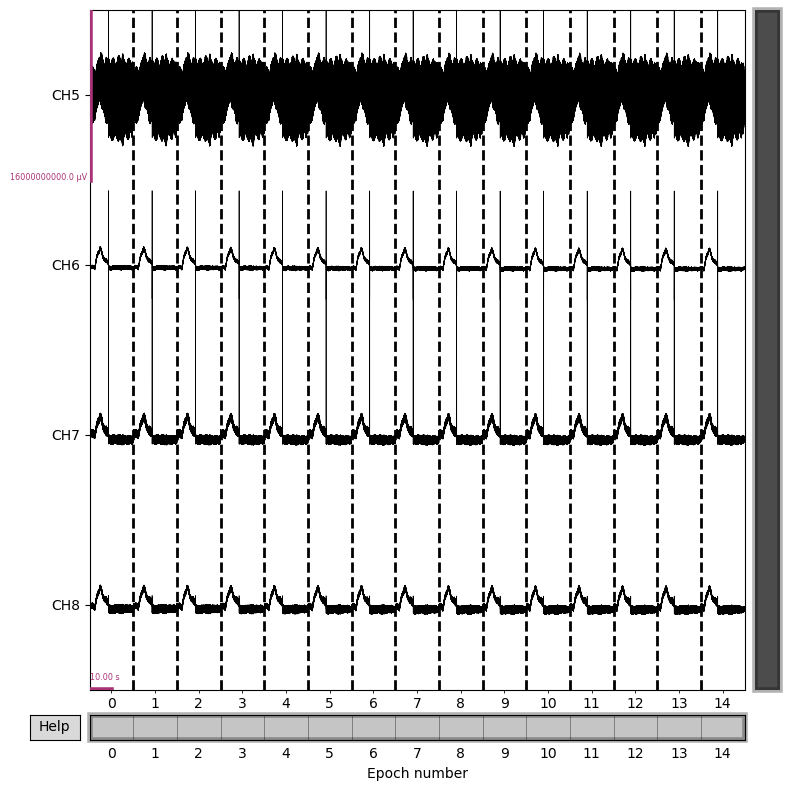

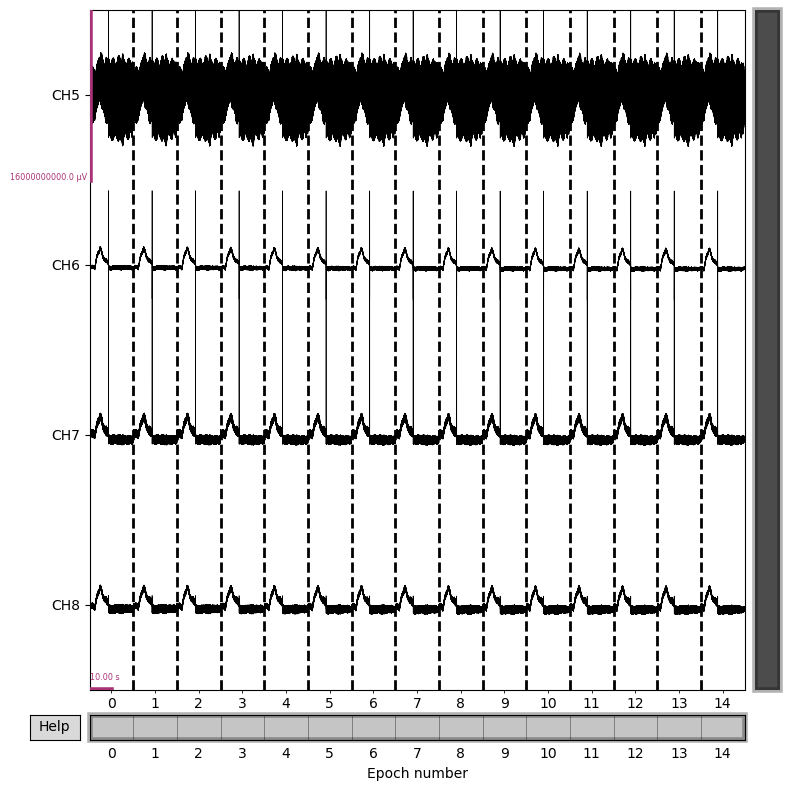

In [27]:
mne_epochs.plot(scalings = 8000)


Setting up band-pass filter from 6 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 6.00, 18.00 Hz: -6.02, -6.02 dB



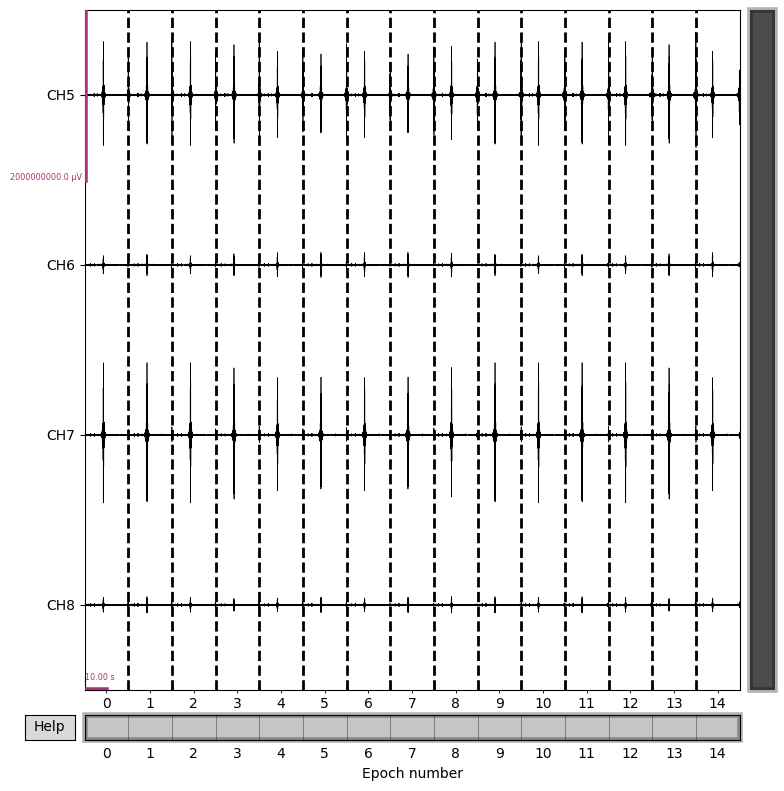

...


In [32]:
mne_epochs.filter(l_freq=6.0, h_freq=18.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}).plot(scalings = 1000)
print('...')

In [33]:
print(mne_epochs.get_data().shape)
mne_epochs.get_data()

(15, 4, 5001)


C:\Users\NARONG\AppData\Local\Temp\ipykernel_27396\23489598.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(mne_epochs.get_data().shape)
C:\Users\NARONG\AppData\Local\Temp\ipykernel_27396\23489598.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  mne_epochs.get_data()


array([[[ 3.60958509e-05,  1.66407380e+02,  3.21159586e+02, ...,
         -3.83747605e+01, -1.98349718e+01, -1.84331224e-03],
        [ 7.19763408e-04,  3.31790668e-01,  6.51605898e-01, ...,
          1.68646992e+01,  8.74734993e+00, -2.74406771e-03],
        [ 2.76953927e-04,  2.48075954e+01,  4.78876769e+01, ...,
         -2.17869385e+00, -1.11722804e+00, -1.55385364e-03],
        [ 6.68933691e-04,  6.08727619e+00,  1.17694342e+01, ...,
          2.37301521e+01,  1.23170450e+01, -2.31636782e-03]],

       [[-1.61194856e-03,  1.67683736e+02,  3.23553908e+02, ...,
         -4.83488560e+01, -2.51157173e+01,  2.26288404e-03],
        [-8.92537049e-04, -8.82638528e-01, -1.72242158e+00, ...,
          1.99929512e+01,  1.03577153e+01,  2.94044911e-03],
        [-7.31860709e-04,  2.40286365e+01,  4.63435386e+01, ...,
         -2.95020639e+00, -1.54205925e+00,  1.79833295e-03],
        [-1.04740511e-03,  4.63359181e+00,  8.90679901e+00, ...,
          2.52756683e+01,  1.30768953e+01,  2.55641

In [35]:
mne_df = mne_epochs.to_data_frame()
mne_df

,time,condition,epoch,CH5,CH6,CH7,CH8
0,0.000,break,0,3.609585e+01,7.197634e+02,2.769539e+02,6.689337e+02
1,0.004,break,0,1.664074e+08,3.317907e+05,2.480760e+07,6.087276e+06
2,0.008,break,0,3.211596e+08,6.516059e+05,4.788768e+07,1.176943e+07
3,0.012,break,0,4.534708e+08,9.484436e+05,6.764099e+07,1.667088e+07
4,0.016,break,0,5.542254e+08,1.209775e+06,8.271344e+07,2.046963e+07
...,...,...,...,...,...,...,...
75010,19.984,backward,14,-3.484664e+08,2.961979e+07,-4.113770e+07,3.910013e+07
75011,19.988,backward,14,-2.848166e+08,2.424026e+07,-3.361458e+07,3.204844e+07
75012,19.992,backward,14,-2.015759e+08,1.716913e+07,-2.378694e+07,2.272276e+07
75013,19.996,backward,14,-1.044088e+08,8.894710e+06,-1.232131e+07,1.177880e+07
